In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
tf.__version__

'2.0.0'

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, 'Not enough GPU hardware devices available'
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import *
from tensorflow.keras import activations

In [4]:
BATCH_SIZE = 10
IMG_SIZE = (128,128,3)
EPOCHS = 100
NUMIMAGES = 2000
BUFFER_SIZE = 200

In [5]:
lambda_cls = 0.2
lambda_flow = 1
lambda_mask = 0.1
lambda_landmark = 10
lambda_reco = 5

In [6]:
from SectionImageLoad import *

In [7]:
from AutoEncoderModel import *
from STNFunction import *
from GeoGAN_losses import *

In [8]:
Ax_filenames_ds,By_filenames_ds,landmark_dict = load_csvdata_weneed()

In [9]:
(Ax,Ax_landmark),(By,By_landmark) = get_raw_image(Ax_filenames_ds,By_filenames_ds,landmark_dict)

In [10]:
def draw_landmark_face(raw_img,raw_landmark):
    img = np.clip((raw_img+1)/2,0,1)
    X = np.clip((raw_landmark[:,0]+1)/2*128,0,128)
    Y = np.clip((raw_landmark[:,1]+1)/2*128,0,128)
    implot = plt.imshow(img)
    plt.scatter(X,Y,c='r',s=5)
    plt.show()

In [11]:
Ax = Ax[:NUMIMAGES]
Ax_landmark = Ax_landmark[:NUMIMAGES]
By = By[:NUMIMAGES]
By_landmark = By_landmark[:NUMIMAGES]

In [12]:
Ax_ds = tf.data.Dataset.from_tensor_slices((Ax, Ax_landmark))
Ax_ds = Ax_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
By_ds = tf.data.Dataset.from_tensor_slices((By, By_landmark))
By_ds = By_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
class generator_model(Model):
    def __init__(self, img_size, batch_size, num_filter=32):
        super(generator_model, self).__init__()
        self.flowNet = autoencoder_model(num_filter,2,img_size,"channels_last","flowNet")
        self.grid_np = np.mgrid[-1:1 + 1e-7 :2 / (img_size[0] - 1), -1:1 + 1e-7:2 / (img_size[1] - 1)]
        self.grid_np = np.moveaxis(self.grid_np, [-2,-1], [0, 1])
        self.flow_grid_np = tf.convert_to_tensor(\
                                np.stack([self.grid_np]*batch_size),
                                                dtype=tf.float32)
        self.test_grid_np = tf.convert_to_tensor(self.grid_np, dtype=tf.float32)
        
        self.maskNet = autoencoder_model(num_filter,1,img_size,"channels_last","maskNet")
        self.refinementNet = autoencoder_model(num_filter,3,img_size,"channels_last","RefinementNet")
        # ------------
        self.removeResidualNet = autoencoder_model(num_filter,3,img_size,"channels_last","RemovalNet")
        
        self.removeconcat = Concatenate(axis=3)
        self.flowconcat = Concatenate(axis=3)
        self.maskconcat = Concatenate(axis=3)
        self.refineconcat = Concatenate(axis=3)
    def call(self, Ax, By, epoch, training=True):
        # Ax_flow is zeros
        fake_Ay, By_flow, raw_By_mask, raw_Ay, By_warpped = self.addAttribute(Ax,By,training)
        fake_Bx = self.removeAttribute(By,raw_By_mask,training)
        
        # fakeBx_flow is zeros
        # (Testing)fake_Ay -> raw_Ay
        fakeBx_to_By, fakeAy_flow, raw_fakeAx_mask, raw_fakeBx_to_By, _ = self.addAttribute(fake_Bx,raw_Ay,training)
        fakeAy_to_Ax = self.removeAttribute(raw_Ay,raw_fakeAx_mask,training)
        
        return_items = {}
        return_items['fake_Ay'] = fake_Ay
        return_items['fakeAy_to_Ax'] = fakeAy_to_Ax
        return_items['fakeBx_to_By'] = fakeBx_to_By
        return_items['fake_Bx'] = fake_Bx
        return_items['flows'] = [By_flow, fakeAy_flow]
        return_items['masks'] = [raw_By_mask, raw_fakeAx_mask]
        return_items['By_warpped'] = By_warpped
        # return_items['raw_Ay'] = raw_Ay
        
        return return_items
    # ----------------------------------------------------------
    def addAttribute(self,Ax,By,training):
        Ax_flow_front, By_flow_front, By_flow, By_warpped = self.callflowNet(Ax,By)
        raw_Ay, By_mask = self.callmaskNet(Ax,By_warpped)
        # Ay, residual_Ay = self.callrefineNet(raw_Ay, By_mask)
        return raw_Ay, By_flow, By_mask, raw_Ay, By_warpped
    def removeAttribute(self,By,mask,training):
        rBy = self.removeResidualNet(self.removeconcat([By,mask]))
        Bx = tf.clip_by_value(By+ 2*tf.keras.activations.tanh(rBy) ,-1,1)
        return Bx
    # ----------------------------------------------------------
    def callflowNet(self, Ax, By, training=True):
        Ax_front = self.flowNet.Encoder(Ax)
        By_front = self.flowNet.Encoder(By)
        fusion_BottleNeck = self.flowconcat([Ax_front, By_front])
        By_flow = self.flowNet.Decoder(fusion_BottleNeck)
        By_warpped = self.warp_flow(By, By_flow, training)
        return Ax_front, By_front, By_flow, By_warpped
    
    def callmaskNet(self,Ax,By_warpped,training=True):
        # maskNet
        Ax_front = self.maskNet.Encoder(Ax)
        By_warpped_front = self.maskNet.Encoder(By_warpped)
        # Blend
        bottleneck_fusion = self.maskconcat([Ax_front,By_warpped_front])
        By_mask = self.maskNet.Decoder(bottleneck_fusion)
        By_mask = Activation('sigmoid')(By_mask)
        Ay = self.blend(By_mask,Ax,By_warpped)
        return Ay, By_mask
    def callrefineNet(self,Ay,By_mask):
        mask_input = tf.stop_gradient(By_mask)
        residual_Ay = self.refinementNet(self.refineconcat([Ay, mask_input]))
        input_refineWeight = 0.1
        refineWeight = input_refineWeight
        residual_Ay = 2*tf.math.tanh(residual_Ay) * refineWeight * By_mask
        Ay = tf.clip_by_value(Ay+residual_Ay,-1,1)
        return Ay, residual_Ay
    # ----------------------------------------------------------
    def warp_flow(self, image, flow, training):
        # flow_grid = self.flow_grid_np + flow
        if training:
            # flow_grid = self.flow_grid_np + flow
            x_s = self.flow_grid_np[:, :, :, 1] + flow[:,:,:,0]
            y_s = self.flow_grid_np[:, :, :, 0] + flow[:,:,:,1]
            warp_image = self.bilinearSampler(image,x_s,y_s)
        else:
            # flow_grid = self.test_grid_np + flow
            x_s = self.flow_grid_np[:, :, :, 1] + flow[:,:,:,0]
            y_s = self.flow_grid_np[:, :, :, 0] + flow[:,:,:,1]
            warp_image = self.bilinearSampler(image,x_s,y_s)
        return warp_image
    
    def bilinearSampler(self,image,grid_x,grid_y):
        return stn_bilinear_sampler(image,grid_x,grid_y)
    # ----------------------------------------------------------
    def blend(self,mask,a,b):
        return mask*a+(1-mask)*b
    # ----------------------------------------------------------
    def save_weights(filepath):
        self.flowNet.save_weights(filepath+'/flowNet.h5')
        self.maskNet.save_weights(filepath+'/maskNet.h5')
        self.refinementNet.save_weights(filepath+'/refinementNet.h5')
        self.removeResidualNet.save_weights(filepath+'/removeResidualNet.h5')

In [14]:
class SinglePatchDisc(Model):
                #       n_layers,input_nc,        ndf,        nc
    def __init__(self,num_layers,img_size,dis_filters,attributes):
        super(SinglePatchDisc,self).__init__()
        self.d_layers = []
        self.d_layers.append(tf.keras.Sequential([ZeroPadding2D(1),
                                           Conv2D(filters=dis_filters,kernel_size=3,strides=2,padding='valid',
                                           input_shape=img_size),
                                           LeakyReLU(alpha=0.2)]))
        nf = dis_filters
        for n in range(1,num_layers):
            nf_prev = nf
            nf = min(nf*2,512)
            self.d_layers.append(tf.keras.Sequential([ZeroPadding2D(1),
                                                      Conv2D(nf,kernel_size=3,strides=2,padding='valid'),
                                                      BatchNormalization(),
                                                      LeakyReLU(alpha=0.2)]))
        nf_prev = nf
        nf = min(nf*2,512)
        self.dilate_layer = []
        for dilate_rate in [2,4,6]:
            self.dilate_layer.append(tf.keras.Sequential([ZeroPadding2D(dilate_rate),
                                                     Conv2D(filters=nf,kernel_size=3,dilation_rate=dilate_rate,padding='valid')]))
        self.dilate_concat = Conv2D(filters=nf,kernel_size=1)
        self.disc_layer = tf.keras.Sequential([ZeroPadding2D(1),
                                               Conv2D(filters=1,kernel_size=3,strides=1,padding='valid')])
        self.attr_layer = tf.keras.Sequential([ZeroPadding2D(1),
                                               Conv2D(filters=attributes,kernel_size=3,strides=1,padding='valid'),
                                               AveragePooling2D(1),
                                               Activation('sigmoid')])
        # self.disc_layer = tf.keras.Sequential([ZeroPadding2D(1),
        #                              Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                              Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                              Flatten(),
        #                              Dense(1, activation='sigmoid')])
        # self.attr_layer = tf.keras.Sequential([ZeroPadding2D(1),
        #                              Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                              Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        #                              LeakyReLU(),
        #                              Dropout(0.3),
        #                             Flatten(),
        #                             Dense(1, activation='sigmoid')])
        self.dilateConcat = Concatenate(axis=3)
    def call(self, img):
        out = img
        feat = []
        for d_layer in self.d_layers:
            out = d_layer(out)
            feat.append(out)
            # if self.dilated:
        dilate_outs = []
        for idx,_ in enumerate([2,4,6]):
            layer = self.dilate_layer[idx](out)
            dilate_outs.append(layer)
        out = self.dilate_concat(self.dilateConcat([dilate_outs[0],dilate_outs[1],dilate_outs[2]]))
        disc_out = self.disc_layer(out)
        attr_out = self.attr_layer(out)
        return feat,disc_out,attr_out
class AttrbuteMultiscalePatchDisc(Model):
    def __init__(self,num_scale=3,img_size=(128,128,3),num_layers=3,dis_filters=32,attributes=1):
        super(AttrbuteMultiscalePatchDisc,self).__init__()
        self.disc = []
        self.num_scale = num_scale
        for rank in range(num_scale):
            self.disc.append(SinglePatchDisc(num_layers,img_size,dis_filters,attributes))
        self.downsampled = tf.keras.Sequential([ZeroPadding2D(1),
                                                AveragePooling2D(pool_size=3,strides=2,padding='valid')])
    def call(self,inputs):
        features, discrims = [],[]
        attr_outs = []
        image_downsampled = inputs
        for i in range(self.num_scale):
            # print("image_shape: {}".format(image_downsampled.shape))
            feat,out,attr_out = self.disc[i](image_downsampled)
            features.append(feat)
            discrims.append(out)
            attr_outs.append(attr_out)
            image_downsampled = self.downsampled(image_downsampled)
        return features,discrims,attr_outs

In [13]:
def build_simple_discriminator_model():
    model_gan = tf.keras.Sequential([ZeroPadding2D(1),
                                     Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
                                     LeakyReLU(),
                                     Dropout(0.3),
                                     Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
                                     LeakyReLU(),
                                     Dropout(0.3),
                                     Flatten(),
                                     Dense(1, activation='sigmoid')])
    model_cls = tf.keras.Sequential([ZeroPadding2D(1),
                                     Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
                                     LeakyReLU(),
                                     Dropout(0.3),
                                     Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
                                     LeakyReLU(),
                                     Dropout(0.3),
                                     Flatten(),
                                     Dense(1, activation='sigmoid')])
    return model_gan, model_cls

In [22]:
del generator
del discriminator

In [15]:
discriminator = AttrbuteMultiscalePatchDisc()

In [14]:
dis_gan, dis_cls = build_simple_discriminator_model()

In [16]:
generator = generator_model(IMG_SIZE,BATCH_SIZE)

In [17]:
flow_loss_func = flow_loss()
lsgan_loss_func = lsgan_loss()
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)

In [18]:
def train_flowNet_step(Ax,By,landmark_Ax,landmark_By,epoch):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        g_items = generator(Ax,By,epoch,True)
        # 1. TV_reg loss
        G_flow_loss = 0.0
        for flow in g_items['flows']:
            G_flow_loss += flow_loss_func.totalVariation_loss(flow)
        G_flow_loss = lambda_flow * tf.cast(G_flow_loss,'float32')
        # 2. landmark loss (By_flow)
        G_land_loss = flow_loss_func.landmark_loss(landmark_By,landmark_Ax,g_items['flows'][0])
        G_land_loss = lambda_landmark * tf.cast(G_land_loss,'float32')
        # 3. recon loss
            # 3-1. mask
        G_mask_loss = 0.0
        for mask in g_items['masks']:
            G_mask_loss += recon_loss(mask,tf.zeros_like(mask))
        G_mask_loss = lambda_mask * tf.cast(G_mask_loss,'float32')
            # 3-2. add-removal recon
        G_rcon_loss = recon_loss(By,g_items['fakeBx_to_By']) + recon_loss(Ax,g_items['fakeAy_to_Ax'])
        G_rcon_loss = lambda_reco * tf.cast(G_rcon_loss,'float32')
        #-------------------------------------------
        
        # 4. GAN loss
        D_fake_loss = 0.0
        D_real_loss = 0.0
        GAN_loss = 0.0
        G_cls_loss = 0.0
        D_cls_loss = 0.0
        # -- For Generator
        for itemname in ['fake_Ay','fakeAy_to_Ax','fakeBx_to_By','fake_Bx']:
            item = g_items[itemname]
            _, pred, attr_pred = discriminator(item)
            for pred_i in pred:
                D_fake_loss += lsgan_loss_func.loss_func(pred_i, False)
                GAN_loss += lsgan_loss_func.loss_func(pred_i, True)
            D_fake_loss = D_fake_loss * 0.5
            
            for attr in attr_pred:
                if itemname in 'fake_Ay' or itemname in 'By':
                    attr_label = tf.ones_like(attr)
                else:
                    attr_label = tf.zeros_like(attr)
                G_cls_loss += lambda_cls * tf.cast(cls_loss(attr,attr_label),'float32')
        # -- For Real Data
        for (img,hasAttr) in [(Ax,False),(By,True)]:
            _, pred, attr_pred = discriminator(img)
            for pred_i in pred:
                D_real_loss += lsgan_loss_func.loss_func(pred_i, True)
            for attr in attr_pred:
                if hasAttr:
                    label = tf.ones_like(attr)
                else:
                    label = tf.zeros_like(attr)
                D_cls_loss += lambda_cls * tf.cast(cls_loss(attr,label),'float32')
        # -- CAST
        D_fake_loss = tf.cast(D_fake_loss,'float32')
        D_real_loss = tf.cast(D_real_loss,'float32')
        GAN_loss = tf.cast(GAN_loss,'float32')
        
        G_loss = G_flow_loss+G_land_loss+G_mask_loss+G_rcon_loss+G_cls_loss+GAN_loss
        D_loss = D_fake_loss+D_real_loss+D_cls_loss
    gradients_of_generator = g_tape.gradient(G_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    gradients_of_discriminator = d_tape.gradient(D_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    # print("flow_loss= {:.3f}, landmark_loss= {:.3f}, mask_loss= {:.3f}, recon_loss= {:.3f}, class_loss= {:.3f}, GAN_loss= {:.3f}".\
    #      format(G_flow_loss,G_land_loss,G_mask_loss,G_rcon_loss,G_cls_loss,GAN_loss))
    # print("D_fake_loss= {:.3f}, D_real_loss= {:.3f}, D_cls_loss= {:.3f}".format(D_fake_loss,D_real_loss,D_cls_loss))
    # print("G_loss= {:.4f}, D_loss= {:.4f}".format(G_loss,D_loss))
    return_items = {}
    return_items["G_flow_loss"] = G_flow_loss
    return_items["G_land_loss"] = G_land_loss
    return_items["G_mask_loss"] = G_mask_loss
    return_items["G_rcon_loss"] = G_rcon_loss
    return_items["G_cls_loss"] = G_cls_loss
    return_items["GAN_loss"] = GAN_loss
    return_items["D_fake_loss"] = D_fake_loss
    return_items["D_real_loss"] = D_real_loss
    return_items["D_cls_loss"] = D_cls_loss
    return_items["G_loss"] = G_loss
    return_items["D_loss"] = D_loss
    return return_items

In [19]:
# -----------------Set TensorBoard
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [20]:
lossnames = ["G_flow_loss","G_land_loss","G_mask_loss","G_rcon_loss","G_cls_loss","GAN_loss",
             "D_fake_loss","D_real_loss","D_cls_loss","G_loss","D_loss"]
metrics_list = []
for itemname in lossnames:
    metrics_list.append(tf.keras.metrics.Mean(itemname, dtype=tf.float32))

for epoch in range(1,EPOCHS+1):
    print("epoch: {}".format(epoch))
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        train_items = train_flowNet_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        for (idx, itemname) in enumerate(lossnames):
            metrics_list[idx](train_items[itemname])
    with train_summary_writer.as_default():
        for (idx, itemname) in enumerate(lossnames):
            tf.summary.scalar(itemname, metrics_list[idx].result(), step=epoch)
            metrics_list[idx].reset_states()

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100


In [16]:
def train_step(Ax,By,landmark_Ax,landmark_By,epoch):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        # Ax_front, By_front, By_flow, By_warpped = generator.callflowNet(Ax,By,training=True)
        g_items = generator(Ax, By, epoch)
        # 1. TV_reg
        G_flow_loss = 0.0
        for flow in g_items['flows']:
            G_flow_loss = flow_loss_func.totalVariation_loss(flow)
        G_flow_loss = lambda_flow * tf.cast(G_flow_loss,'float32') * 128
        # 2. Landmark loss
        G_land_loss = flow_loss_func.landmark_loss(landmark_By,landmark_Ax,g_items['flows'][0])
        G_land_loss = lambda_landmark * tf.cast(G_land_loss,'float32')
        # 3. Mask Reconstruction loss
        # G_mask_loss = 0.0
        # for mask in g_items['masks']:
        #     G_mask_loss += recon_loss(mask,tf.zeros_like(mask))
        # G_mask_loss = lambda_mask * tf.cast(G_mask_loss,'float32')
        # 4. Reconstruction loss
        G_reco_loss = recon_loss(g_items['fakeAy_to_Ax'],Ax) + recon_loss(g_items['fakeBx_to_By'],By)
        G_reco_loss = lambda_reco * tf.cast(G_reco_loss,'float32')
        # 5. Classification & LSGAN
        G_GAN_loss = 0.0
        G_cls_loss = 0.0
        D_GAN_loss = 0.0
        _, pred, attr_pred = discriminator(g_items['fake_Ay'])
        for pred_i in pred:
            D_GAN_loss += lsgan_loss_func.loss_func(pred_i,False)
            G_GAN_loss += lsgan_loss_func.generator_loss(pred_i)
        for attr_pred_i in attr_pred:
            G_cls_loss += cls_loss(attr_pred_i,tf.ones_like(attr_pred_i))
        # --------------------
        _, pred, attr_pred = discriminator(g_items['fakeAy_to_Ax'])
        for pred_i in pred:
            D_GAN_loss += lsgan_loss_func.loss_func(pred_i,False)
            G_GAN_loss += lsgan_loss_func.generator_loss(pred_i)
        for attr_pred_i in attr_pred:
            G_cls_loss += cls_loss(attr_pred_i,tf.zeros_like(attr_pred_i))
        # --------------------
        _, pred, attr_pred = discriminator(g_items['fakeBx_to_By'])
        for pred_i in pred:
            D_GAN_loss += lsgan_loss_func.loss_func(pred_i,False)
            G_GAN_loss += lsgan_loss_func.generator_loss(pred_i)
        for attr_pred_i in attr_pred:
            G_cls_loss += cls_loss(attr_pred_i,tf.ones_like(attr_pred_i))
        # --------------------
        _, pred, attr_pred = discriminator(g_items['fake_Bx'])
        for pred_i in pred:
            D_GAN_loss += lsgan_loss_func.loss_func(pred_i,False)
            G_GAN_loss += lsgan_loss_func.generator_loss(pred_i)
        for attr_pred_i in attr_pred:
            G_cls_loss += cls_loss(attr_pred_i,tf.zeros_like(attr_pred_i))
        
        G_cls_loss = lambda_cls * tf.cast(G_cls_loss,'float32')
        G_GAN_loss = tf.cast(G_GAN_loss,'float32')
        D_GAN_loss = D_GAN_loss*0.5
        
        G_loss = G_GAN_loss + G_cls_loss + G_reco_loss + G_land_loss + G_flow_loss
        # print("G_flow_loss={:.5f},G_land_loss={:.5f},G_mask_loss:{:.5f}".format(G_flow_loss,G_land_loss,G_mask_loss))
        # ----------------------------------------------------------
        # All_fake = tf.concat([g_items['fake_Ay'],g_items['fakeAy_to_Ax'],
        #                      g_items['fakeAy_to_Ax'],g_items['fake_Bx']],axis=0)
        # 1. Classification & LSGAN
        D_cls_loss = 0.0
        real_pred = []
        _, pred, attr_pred = discriminator(Ax)
        for pred_i in pred:
            D_GAN_loss += lsgan_loss_func.loss_func(pred_i,True)
        for attr_pred_i in attr_pred:
            D_cls_loss += cls_loss(attr_pred_i,tf.zeros_like(attr_pred_i))
            
        _, pred, attr_pred = discriminator(By)
        for pred_i in pred:
            D_GAN_loss += lsgan_loss_func.loss_func(pred_i,True)
        for attr_pred_i in attr_pred:
            D_cls_loss += cls_loss(attr_pred_i,tf.ones_like(attr_pred_i))
        D_cls_loss = lambda_cls * tf.cast(D_cls_loss,'float32')
        D_GAN_loss = tf.cast(D_GAN_loss,'float32')
        D_loss = D_GAN_loss + D_cls_loss
        print("G_loss: {:.5f}, D_loss: {:.5f}".format(G_loss,D_loss))
    gradients_of_generator = g_tape.gradient(G_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    gradients_of_discriminator = d_tape.gradient(D_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return_items = {}
    return_items['G_flow_loss'] = G_flow_loss
    return_items['G_land_loss'] = G_land_loss
    # return_items['G_mask_loss'] = G_mask_loss
    return_items['G_reco_loss'] = G_reco_loss
    return_items['G_GAN_loss'] = G_GAN_loss
    return_items['G_cls_loss'] = G_cls_loss
    return_items['D_GAN_loss'] = D_GAN_loss
    return_items['D_cls_loss'] = D_cls_loss
    return return_items

In [34]:
flow_loss_func = flow_loss()
lsgan_loss_func = lsgan_loss()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
gan_optimizer = tf.keras.optimizers.Adam(1e-4)
cls_optimizer = tf.keras.optimizers.Adam(1e-4)

In [35]:
def train_step(Ax,By,landmark_Ax,landmark_By,epoch):
    with tf.GradientTape() as g_tape, tf.GradientTape() as gan_tape, tf.GradientTape() as cls_tape:
        # Ax_front, By_front, By_flow, By_warpped = generator.callflowNet(Ax,By,training=True)
        g_items = generator(Ax, By, epoch)
        # 1. TV_reg
        G_flow_loss = 0.0
        for flow in g_items['flows']:
            G_flow_loss = flow_loss_func.totalVariation_loss(flow)
        G_flow_loss = lambda_flow * tf.cast(G_flow_loss,'float32') * 128
        # 2. Landmark loss
        G_land_loss = flow_loss_func.landmark_loss(landmark_By,landmark_Ax,g_items['flows'][0])
        G_land_loss = lambda_landmark * tf.cast(G_land_loss,'float32')
        # 3. Mask Reconstruction loss
        # G_mask_loss = 0.0
        # for mask in g_items['masks']:
        #     G_mask_loss += recon_loss(mask,tf.zeros_like(mask))
        # G_mask_loss = lambda_mask * tf.cast(G_mask_loss,'float32')
        # 4. Reconstruction loss
        G_reco_loss = recon_loss(g_items['fakeAy_to_Ax'],Ax) + recon_loss(g_items['fakeBx_to_By'],By)
        G_reco_loss = lambda_reco * tf.cast(G_reco_loss,'float32')
        # 5. Classification & LSGAN
        G_GAN_loss = 0.0
        G_cls_loss = 0.0
        D_GAN_loss = 0.0
        pred = dis_gan(g_items['fake_Ay'])
        attr_pred = dis_cls(g_items['fake_Ay'])
        D_GAN_loss += lsgan_loss_func.loss_func(pred,False)
        G_GAN_loss += lsgan_loss_func.generator_loss(pred)
        G_cls_loss += cls_loss(attr_pred,tf.ones_like(attr_pred))
        # --------------------
        pred = dis_gan(g_items['fakeAy_to_Ax'])
        attr_pred = dis_cls(g_items['fakeAy_to_Ax'])
        D_GAN_loss += lsgan_loss_func.loss_func(pred,False)
        G_GAN_loss += lsgan_loss_func.generator_loss(pred)
        G_cls_loss += cls_loss(attr_pred,tf.ones_like(attr_pred))
        # --------------------
        pred = dis_gan(g_items['fakeBx_to_By'])
        attr_pred = dis_cls(g_items['fakeBx_to_By'])
        D_GAN_loss += lsgan_loss_func.loss_func(pred,False)
        G_GAN_loss += lsgan_loss_func.generator_loss(pred)
        G_cls_loss += cls_loss(attr_pred,tf.ones_like(attr_pred))
        # --------------------
        pred = dis_gan(g_items['fake_Bx'])
        attr_pred = dis_cls(g_items['fake_Bx'])
        D_GAN_loss += lsgan_loss_func.loss_func(pred,False)
        G_GAN_loss += lsgan_loss_func.generator_loss(pred)
        G_cls_loss += cls_loss(attr_pred,tf.ones_like(attr_pred))
        
        G_cls_loss = lambda_cls * tf.cast(G_cls_loss,'float32')
        G_GAN_loss = tf.cast(G_GAN_loss,'float32')
        D_GAN_loss = D_GAN_loss*0.5
        
        G_loss = G_GAN_loss + G_cls_loss + G_reco_loss + G_land_loss + G_flow_loss
        # print("G_flow_loss={:.5f},G_land_loss={:.5f},G_mask_loss:{:.5f}".format(G_flow_loss,G_land_loss,G_mask_loss))
        # ----------------------------------------------------------
        # All_fake = tf.concat([g_items['fake_Ay'],g_items['fakeAy_to_Ax'],
        #                      g_items['fakeAy_to_Ax'],g_items['fake_Bx']],axis=0)
        # 1. Classification & LSGAN
        D_cls_loss = 0.0
        real_pred = []
        pred = dis_gan(Ax)
        attr_pred = dis_cls(Ax)
        D_GAN_loss += lsgan_loss_func.loss_func(pred,True)
        D_cls_loss += cls_loss(attr_pred,tf.zeros_like(attr_pred))
        
        pred = dis_gan(By)
        attr_pred = dis_cls(By)
        D_GAN_loss += lsgan_loss_func.loss_func(pred,True)
        D_cls_loss += cls_loss(attr_pred,tf.zeros_like(attr_pred))
        
        D_cls_loss = lambda_cls * tf.cast(D_cls_loss,'float32')
        D_GAN_loss = tf.cast(D_GAN_loss,'float32')
        D_loss = D_GAN_loss + D_cls_loss
        print("G_loss: {:.5f}, D_loss: {:.5f}".format(G_loss,D_loss))
    gradients_of_generator = g_tape.gradient(G_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    gradients_of_gan = gan_tape.gradient(D_GAN_loss,dis_gan.trainable_variables)
    gan_optimizer.apply_gradients(zip(gradients_of_gan, dis_gan.trainable_variables))
    
    gradients_of_cls = cls_tape.gradient(D_cls_loss,dis_cls.trainable_variables)
    cls_optimizer.apply_gradients(zip(gradients_of_cls, dis_cls.trainable_variables))
    return_items = {}
    return_items['G_flow_loss'] = G_flow_loss
    return_items['G_land_loss'] = G_land_loss
    # return_items['G_mask_loss'] = G_mask_loss
    return_items['G_reco_loss'] = G_reco_loss
    return_items['G_GAN_loss'] = G_GAN_loss
    return_items['G_cls_loss'] = G_cls_loss
    return_items['D_GAN_loss'] = D_GAN_loss
    return_items['D_cls_loss'] = D_cls_loss
    return return_items

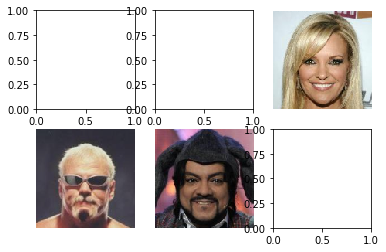

In [30]:
testAx = Ax[333]
testBy = By[333]
testAy = By[455]
fig,axes=plt.subplots(2,3)
ax1=axes[0,2]
ax1.axis('off')
ax2=axes[1,0]
ax2.axis('off')
ax3=axes[1,1]
ax3.axis('off')
ax1.imshow(testAx+1)
ax2.imshow(testBy+1)
ax3.imshow(testAy+1)
plt.savefig('image_at_epoch_test.png')

In [36]:
def save_images(Ax,By,Ay,epoch,batch_size):
    fig = plt.figure(figsize=(75, 75)) 
    gs = matplotlib.gridspec.GridSpec(batch_size, 3, width_ratios=[1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
    Ax = np.clip(Ax+1,0,1)
    By = np.clip(By+1,0,1)
    Ay = np.clip(Ay.numpy()+1,0,1)
    for i in range(batch_size):
        ax1=plt.subplot(gs[i,0])
        ax1.axis('off')
        ax2=plt.subplot(gs[i,1])
        ax2.axis('off')
        ax3=plt.subplot(gs[i,2])
        ax3.axis('off')
        ax1.imshow(Ax[i])
        ax2.imshow(By[i])
        ax3.imshow(Ay[i])
    plt.savefig('image3_at_epoch_{}.png'.format(epoch))

In [21]:
test_Ax_iter = iter(Ax_ds)
test_By_iter = iter(By_ds)
testAx, testAxMark = next(test_Ax_iter)
testBy, testByMark = next(test_By_iter)
test_Ax_front, test_By_front, test_By_flow, test_By_warpped = generator.callflowNet(testAx,testBy,False)
test_raw_Ay, test_By_mask = generator.callmaskNet(testAx,test_By_warpped)
testAxMark2 = tf.expand_dims(testAxMark,1)
testByMark2 = tf.expand_dims(testByMark,1)
test_sampled_flow = stn_bilinear_sampler(test_By_flow,testAxMark2[:,:,:,0],testAxMark2[:,:,:,1])

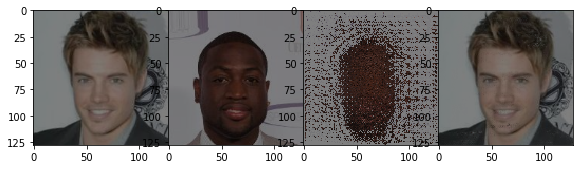

In [32]:
fig = plt.figure(figsize=(75, 75))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1],
        wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.1, right=0.2)
img_idx = 3
imgs = [testAx[img_idx],testBy[img_idx],test_By_warpped[img_idx],test_raw_Ay[img_idx]]
for idx,img in enumerate(imgs):
    ax = plt.subplot(gs[0,idx])
    ax.imshow(np.clip((img+1)/2,0,1))

In [33]:
test_target_flow = (testByMark[img_idx]-testAxMark[img_idx])

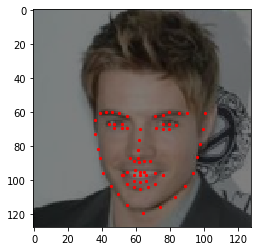

In [34]:
draw_landmark_face(testAx[img_idx],testAxMark[img_idx])

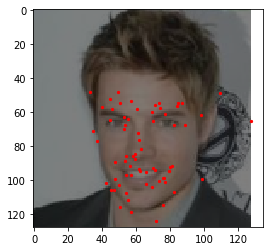

In [35]:
draw_landmark_face(testAx[img_idx],-test_sampled_flow[img_idx][0]+tf.cast(testByMark[0],'float'))

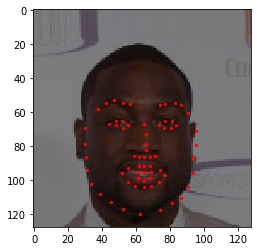

In [36]:
draw_landmark_face(testBy[img_idx],testByMark[img_idx])

In [37]:
template = ('G_flow_loss: {:.4f}, G_land_loss: {:.4f}, G_reco_loss: {:.4f}, G_GAN_loss: {:.4f}'
           ' G_cls_loss: {:.4f}, D_GAN_loss: {:.4f}, D_cls_loss: {:.4f}')
for epoch in range(1,EPOCHS+1):
    count = 0
    for (one_Ax, one_Ax_landmark), (one_By, one_By_landmark) in zip(Ax_ds, By_ds):
        count = count + 1
        loss_items = train_step(one_Ax,one_By,one_Ax_landmark,one_By_landmark,tf.cast(epoch,'float32'))
        print(template.format(loss_items['G_flow_loss'],loss_items['G_land_loss'],
                             loss_items['G_reco_loss'],loss_items['G_GAN_loss'],loss_items['G_cls_loss'],
                             loss_items['D_GAN_loss'],loss_items['D_cls_loss']))
        #with train_summary_writer.as_default():
            # tf.summary.scalar('G_flow_loss', loss_items['G_flow_loss'], step=epoch)
            # tf.summary.scalar('G_land_loss', loss_items['G_land_loss'], step=epoch)
            # tf.summary.scalar('G_mask_loss', loss_items['G_mask_loss'], step=epoch)
            # tf.summary.scalar('G_reco_loss', loss_items['G_reco_loss'], step=epoch)
            # tf.summary.scalar('G_GAN_loss', loss_items['G_GAN_loss'] , step=epoch)
            # tf.summary.scalar('G_cls_loss', loss_items['G_cls_loss'] , step=epoch)
            # tf.summary.scalar('D_GAN_loss', loss_items['D_GAN_loss'] , step=epoch)
            # tf.summary.scalar('D_cls_loss', loss_items['D_cls_loss'] , step=epoch)
    test_Ax_iter = iter(Ax_ds)
    test_By_iter = iter(By_ds)
    testAx, _ = next(test_Ax_iter)
    testBy, _ = next(test_By_iter)
    testAy = generator(testAx,testBy,tf.cast(epoch,'float32'))
    save_images(testAx,testBy,testAy['By_warpped'],epoch,BATCH_SIZE)
    By_ds = tf.data.Dataset.from_tensor_slices((By, By_landmark))
    By_ds = By_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

G_loss: 13.85335, D_loss: 4.06180
G_flow_loss: 1.9100, G_land_loss: 1.4179, G_reco_loss: 3.3556, G_GAN_loss: 0.9584 G_cls_loss: 6.2114, D_GAN_loss: 0.9824, D_cls_loss: 3.0794
G_loss: 14.12093, D_loss: 2.90106
G_flow_loss: 1.2676, G_land_loss: 1.2427, G_reco_loss: 2.9768, G_GAN_loss: 0.8383 G_cls_loss: 7.7956, D_GAN_loss: 0.8875, D_cls_loss: 2.0136
G_loss: 14.65391, D_loss: 1.93830
G_flow_loss: 0.8360, G_land_loss: 0.8950, G_reco_loss: 2.6612, G_GAN_loss: 0.8442 G_cls_loss: 9.4175, D_GAN_loss: 0.8431, D_cls_loss: 1.0952
G_loss: 15.41658, D_loss: 1.36354
G_flow_loss: 0.6201, G_land_loss: 0.8021, G_reco_loss: 2.4028, G_GAN_loss: 0.9499 G_cls_loss: 10.6417, D_GAN_loss: 0.8224, D_cls_loss: 0.5411
G_loss: 15.79264, D_loss: 1.13238
G_flow_loss: 0.5680, G_land_loss: 0.6525, G_reco_loss: 2.1717, G_GAN_loss: 1.0408 G_cls_loss: 11.3596, D_GAN_loss: 0.8550, D_cls_loss: 0.2773
G_loss: 15.78065, D_loss: 1.12329
G_flow_loss: 0.5520, G_land_loss: 0.5057, G_reco_loss: 2.0938, G_GAN_loss: 0.9781 G_cls_l

KeyboardInterrupt: 

In [12]:
By_iter = iter(By_ds)
for one_Ax, one_Ax_landmark in Ax_ds:
    one_By, one_By_landmark = next(By_iter)
    tmp_Ax = generator.flowNet.Encoder(one_Ax)
    tmp_By = generator.flowNet.Encoder(one_By)
    fusion_BottleNeck = tf.concat([tmp_Ax, tmp_By], axis=3)
    tmp_Decoder = generator.flowNet.Decoder(fusion_BottleNeck)
    '''tmp_Ax = generator.flowNet.ZeroPadding2D1(one_Ax)
    Conv1_Ax = generator.flowNet.Conv1(tmp_Ax)
    Bn1_Ax = generator.flowNet.norm1(Conv1_Ax)
    relu1_Ax = activations.relu(Bn1_Ax)
    Conv2_Ax = generator.flowNet.Conv2(relu1_Ax)
    Bn2_Ax = generator.flowNet.norm2(Conv2_Ax)
    relu2_Ax = activations.relu(Bn2_Ax)
    Conv3_Ax = generator.flowNet.Conv2(relu2_Ax)
    Bn3_Ax = generator.flowNet.norm2(Conv3_Ax)
    relu3_Ax = activations.relu(Bn3_Ax)
    Conv3_Ax = self.Conv4(self.Conv3_out)
    Conv4_out = self.norm1(Conv4_out)
    Conv4_out = activations.relu(Conv4_out)'''
    # tf.math.reduce_std
    print("---------------Ax---------------")
    print(tf.math.reduce_mean(tmp_Decoder[0]))
    print("---------------By---------------")
    # print(tmp_By[0])
    break

---------------Ax---------------
tf.Tensor(-0.18513003, shape=(), dtype=float32)
---------------By---------------


In [23]:
By_ds = tf.data.Dataset.from_tensor_slices((By, By_landmark))
By_ds = By_ds.shuffle(10000).batch(BATCH_SIZE)

In [16]:
# Test
Ax_front = None
By_front = None
By_flow = None
By_warpped = None
By_iter = iter(By_ds)
for one_Ax, one_Ax_landmark in Ax_ds:
    one_By, one_By_landmark = next(By_iter)
    Ax_front, By_front, By_flow, By_warpped = generator.callflowNet(one_Ax,one_By,training=False)
    break

In [ ]:
from util.flow_util import *

In [24]:
tf.math.reduce_std(By_warpped[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.27254024>

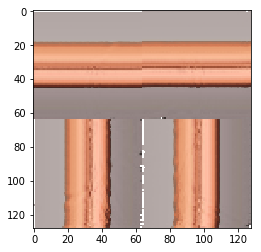

In [17]:
test_warpped = np.clip(By_warpped[8].numpy()+1, 0, 1, out=None)
plt.figure()
plt.imshow(test_warpped)